In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Class definition

In [2]:
class hh_neuron:
    
    def __init__(self, my_id, config={}):
        self.C = 1.
        self.g_Na = 120.
        self.g_K = 36.
        self.g_L = .3
        self.E_Na = 50.
        self.E_K = -77.
        self.E_L = -54.5
        self.I_ext = 10.
        self.tau_d = 3.
        self.tau_r = .1
        self.sim_n = 1
        self.id = my_id
        
        if 'C' in config.keys():
            self.C = config['C']
        if 'g_Na' in config.keys():
            self.g_Na = config['g_Na']
        if 'g_K' in config.keys():
            self.g_K = config['g_K']
        if 'g_L' in config.keys():
            self.g_L = config['g_L']
        if 'E_Na' in config.keys():
            self.E_Na = config['E_Na']
        if 'E_K' in config.keys():
            self.E_K = config['E_K']
        if 'E_L' in config.keys():
            self.E_L = config['E_L']
        if 'I_ext' in config.keys():
            self.I_ext = config['I_ext']
        if 'tau_d' in config.keys():
            self.tau_d = config['tau_d']
        if 'tau_r' in config.keys():
            self.tau_r = config['tau_r']
        
        self.inc = []
        self.outc = []

    def alpha_m(self, V):
        """S5"""
        return .1 * (V + 40.) / (1. - np.exp(-(V + 40.) / 10.))

    def beta_m(self, V):
        """S6"""
        return 4. * np.exp(-(V + 65.) / 18.)

    def alpha_h(self, V):
        """S7"""
        return .07 * np.exp(-(V + 65.) / 20.)

    def beta_h(self, V):
        """S8"""
        return 1. / (1. + np.exp(-(V + 35.) / 10.))

    def alpha_n(self, V):
        """S9
        "/ 10" appears to be a typo in the paper.
        Other resources say "/ 100" """
        return ((V + 55.) / 100.) / (1. - np.exp((-.1) * (V + 55.)))

    def beta_n(self, V):
        """S10"""
        return .125 * np.exp(-(V + 65.) / 80.)

    def dm(self, V, m):
        """S2"""
        a = self.alpha_m(V)
        b = self.beta_m(V)

        return a * (1. - m) - b * m

    def dh(self, V, h):
        """S3"""
        a = self.alpha_h(V)
        b = self.beta_h(V)

        return a * (1. - h) - b * h

    def dn(self, V, n):
        """S4"""
        a = self.alpha_n(V)
        b = self.beta_n(V)

        return a * (1. - n) - b * n

    def dV(self, V, m, h, n, I_syn=0):
        """S1"""
        return (- self.g_Na * m ** 3 * h * (V - self.E_Na) 
                - self.g_K * n ** 4 * (V - self.E_K) 
                - self.g_L * (V - self.E_L) 
                + self.I_ext + I_syn ) / self.C
    
    def register_in(self, connection):
        self.inc.append(connection)
        
    def register_out(self, connection):
        self.outc.append(connection)

In [3]:
class Connection():
    
    def __init__(self, neuron_a, neuron_b, tau_l, E_syn):
        self.neuron_a = neuron_a
        self.neuron_b = neuron_b
        self.neuron_a.register_out(self)
        self.neuron_b.register_in(self)
        self.tau_l = tau_l
        self.E_syn = E_syn
        
    def alpha(self, t):
        """S11"""
        return 1 / (tau_d - tau_r) * (np.exp(-t / tau_d) - np.exp(-t / tau_r))
    
    def I_syn(self, t, t_spikes): 
        """S12 for a single connection"""
        return - g_max / N * np.sum(self.alpha(t - t_spikes - self.tau_l)) * (V[self.neuron_a.id, int(t / step_size)] - self.E_syn)

In [4]:
from scipy.signal import argrelextrema

def is_spike(V):
    return V > 20

def get_spike_times(t, V):
    return t[argrelextrema(V, np.greater)]

## Configuration

In [5]:
np.random.seed(42)

hh_config = {
    'C': 1.,
    'g_Na': 120.,
    'g_K': 36.,
    'g_L': .3,
    'E_Na': 50.,
    'E_K': -77.,
    'E_L': -54.5,
    'I_ext': 10.
}

tau_d = 3.
tau_r = .1
g_max = .05
N = 500.

step_size = .02
t0 = 0.
m0 = 0.05
h0 = 0.6
n0 = 0.32
V0 = -30.

t_end = 120.

t = np.arange(t0, t_end, step_size)

hh_alpha = hh_neuron(0, hh_config)
hh_beta = hh_neuron(1, hh_config)
hh_gamma = hh_neuron(2, hh_config)
neurons = [hh_alpha, hh_beta, hh_gamma]

# connect neurons
connections = []
connections.append(Connection(hh_alpha, hh_gamma, 8., 0.))
connections.append(Connection(hh_gamma, hh_alpha, 8., 0.))
connections.append(Connection(hh_beta, hh_gamma, 8., 0.))
connections.append(Connection(hh_gamma, hh_alpha, 8., 0.))

## Simulation

In [6]:
def simulate(t):
    
    for i in range(1, t.size):

        m_i = np.zeros(len(neurons))
        h_i = np.zeros(len(neurons))
        n_i = np.zeros(len(neurons))
        V_i = np.zeros(len(neurons))

        for j, neuron in enumerate(neurons):

            # intermediate
            m_i[j] = m[j, i-1] + step_size * neuron.dm(V[j, i-1], m[j, i-1])
            h_i[j] = h[j, i-1] + step_size * neuron.dh(V[j, i-1], h[j, i-1])
            n_i[j] = n[j, i-1] + step_size * neuron.dn(V[j, i-1], n[j, i-1])
            
            I_syn_i = 0
            for c in neuron.inc:
                t_spikes = get_spike_times(t[:i], V[c.neuron_a.id, :i])
                I_syn_i += c.I_syn(i * step_size, t_spikes)
            
            V_i[j] = V[j, i-1] + step_size * neuron.dV(V[j, i-1], m[j, i-1], h[j, i-1], n[j, i-1], I_syn_i)

            # heun
            m[j, i] = m[j, i-1] + (step_size / 2.) * (neuron.dm(V[j, i-1], m[j, i-1]) + neuron.dm(V_i[j], m_i[j]))
            h[j, i] = h[j, i-1] + (step_size / 2.) * (neuron.dh(V[j, i-1], h[j, i-1]) + neuron.dh(V_i[j], h_i[j]))
            n[j, i] = n[j, i-1] + (step_size / 2.) * (neuron.dn(V[j, i-1], n[j, i-1]) + neuron.dn(V_i[j], n_i[j]))
            
            I_syn = 0
            for c in neuron.inc:
                t_spikes = get_spike_times(t[:i+1], V[c.neuron_a.id, :i+1])
                I_syn += c.I_syn(i * step_size, t_spikes)
            
            V[j, i] = V[j, i-1] + (step_size / 2.) * (neuron.dV(V[j, i-1], m[j, i-1], h[j, i-1], n[j, i-1]) + neuron.dV(V_i[j], m[j, i], h[j, i], n[j, i], I_syn))


In [7]:
# warmup
m = np.zeros((len(neurons), t.size))
m[:, 0] = m0
h = np.zeros((len(neurons), t.size))
h[:, 0] = h0
n = np.zeros((len(neurons), t.size))
n[:, 0] = n0 
V = np.zeros((len(neurons), t.size))
V[:, 0] = V0
simulate(t)

# cut first phase
wu_len = int(14.7 / step_size)
m = m[:, wu_len:]
h = h[:, wu_len:]
n = n[:, wu_len:]
V = V[:, wu_len:]

# shift phases randomly
m0 = np.zeros(len(neurons))
h0 = np.zeros(len(neurons))
n0 = np.zeros(len(neurons))
V0 = np.zeros(len(neurons))
for j in range(len(neurons)):
    shift = int(np.random.rand() * 14.7 / step_size)
    
    m[j] = np.roll(m[j], shift)
    h[j] = np.roll(h[j], shift)
    n[j] = np.roll(n[j], shift)
    V[j] = np.roll(V[j], shift)
    
    m0[j] = m[j, -1]
    h0[j] = h[j, -1]
    n0[j] = n[j, -1]
    V0[j] = V[j, -1]
    
# simulate
t = np.arange(t0, t_end, step_size)
m = np.zeros((len(neurons), t.size))
m[:, 0] = m0
h = np.zeros((len(neurons), t.size))
h[:, 0] = h0
n = np.zeros((len(neurons), t.size))
n[:, 0] = n0 
V = np.zeros((len(neurons), t.size))
V[:, 0] = V0
simulate(t)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: overflow encountered in exp
/usr/lib/python3/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: overflow encountered in exp
/usr/lib/python3/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in exp
/usr/lib/python3/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: overflow encountered in exp
/usr/lib/python3/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: overflow encountered in exp
/usr/lib/python3/dist-packages/ipykernel_launcher.py:65: RuntimeWarning: overflow encountered in exp
/usr/lib/python3/dist-packages/ipykernel_launcher.py:93: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in double_scalars
/usr/lib/python3/dist-packages/scipy/signal/_peak_finding.py:77: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, plus)
/usr/lib/py

## Plotting

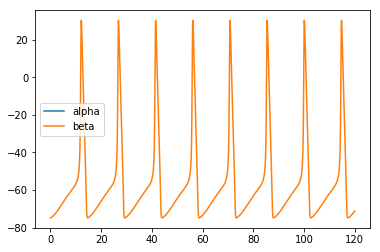

(array([], dtype=int64),)


/usr/lib/python3/dist-packages/scipy/signal/_peak_finding.py:77: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, plus)
/usr/lib/python3/dist-packages/scipy/signal/_peak_finding.py:78: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, minus)


ValueError: x and y must have same first dimension, but have shapes (0,) and (1,)

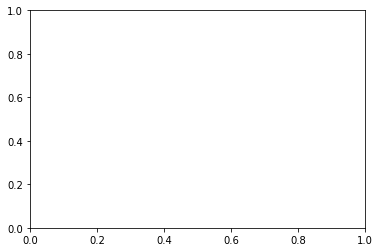

In [12]:
# only plot alhpa and beta to visualize synchronization
for j in range(len(neurons) - 1):
    plt.plot(t, V[j])
plt.legend(["alpha", "beta", "gamma"])
plt.show()

# plot spikes
for j in range(len(neurons)):
    spikes = argrelextrema(V[j], np.greater)
    n_spikes = len(spikes)
    print(spikes)
    y_val = np.full((n_spikes), 1)
    plt.plot(t[spikes], y_val, ".")

plt.legend(["alhpa", "beta", "gamma"])
plt.show()